In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.base import BaseEstimator, TransformerMixin

import warnings

warnings.filterwarnings('ignore')
sns.set()

# Po co nam szeregi czasowe?
* Prognozy gospodarcze
* Prognozy sprzedażowe
* Analizy rynku akcji /surowców / nieruchomości
* Prognozy plonów
* Prognozowanie zużycia gazu
* Monitorowanie działania sprzętu technologicznego

Podstawa kluczowych i strategicznych decyzji

## Po co nam ML dla szeregów czasowych
### Zalety
1. Wyższa dokładność prognoz 
2. Nieliniowe zależności
3. Duża ilość danych, wiele wymiarów
4. Wydajność obliczeń

### Wady
1. ML nie zawsze ma sens
Jeżeli metody statystyczne są wystarczające np ARIMA, to nie ma sensu stosować ML. Czasami ARIMA będzie lepsza niż np. Rekurencyjna Sieć Neuronowa (bo ta potrzebuje dużo danych)
2. Problem z tłumaczeniem modeli (tzw. modele - czarne skrzynki)
Często NN mają wspaniałe wyniki ale nie wiadomo dlaczego. 

## Szeregi czasowe vs. Regresja

**Czas jest wszystkim** - Napoleon I
cytaty...

### Szeregi czasowe
* kolejność jest kluczowa

1. Dane zawierają jaką zmienną które odzwierciedlają czas lub kolejność - index czasowy
2. Dane są posortowane
3. Indeks czasowy ma stabilną częstotliwość

### Jak zmusić dane do bycia szeregiem czasowym?
1. Wprowadzić sztuczną kolumnę z kolejnością 1,2,3,4
2. Pososrtować index czasowy
3. Ponowne próbkowanie (resampling) z potrzebną częstotliwością

### Z pustego i Salomon nie naleje - wartości brakujące
1. Fill Forward - wartość brakująca taka jak poprzednia
2. Backfilling - wartość brakująca tak jak następna
3. Interpolacja - wartość pośrodku pomiędzy istniejącymi wartościami
4. Wartość średnia / mediana

In [4]:
DATA_URL = '/Users/dravik/PycharmProjects/ML_exercises/Sages - Uczenie maszynowe dla szeregow czasowych/metro_data.csv'

raw_df = pd.read_csv(DATA_URL)
raw_df.head()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2015-06-11 20:00:00,None,287.586,0.0,0.0,92,Rain,light rain,2886
1,2015-06-12 18:00:00,None,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2,2015-06-12 20:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3095
3,2015-06-12 21:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3299
4,2015-06-13 21:00:00,None,294.840,0.0,0.0,76,Clouds,broken clouds,3040


In [5]:
raw_df.tail()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
32228,2018-09-30 19:00:00,None,283.45,0.0,0.0,75,Clouds,broken clouds,3543
32229,2018-09-30 20:00:00,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2781
32230,2018-09-30 21:00:00,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159
32231,2018-09-30 22:00:00,None,282.09,0.0,0.0,90,Clouds,overcast clouds,1450
32232,2018-09-30 23:00:00,None,282.12,0.0,0.0,90,Clouds,overcast clouds,954


In [6]:
raw_df.shape

(32233, 9)

In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32233 entries, 0 to 32232
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            32233 non-null  object 
 1   holiday              32233 non-null  object 
 2   temp                 32233 non-null  float64
 3   rain_1h              32233 non-null  float64
 4   snow_1h              32233 non-null  float64
 5   clouds_all           32233 non-null  int64  
 6   weather_main         32233 non-null  object 
 7   weather_description  32233 non-null  object 
 8   traffic_volume       32233 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 2.2+ MB


In [8]:
raw_df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,32233.000000,32233.000000,32233.000000,32233.000000,32233.000000
mean,282.955665,0.420472,0.000333,47.290293,3258.114851
std,12.120323,54.766368,0.009986,39.734834,1973.534323
min,243.390000,0.000000,0.000000,0.000000,0.000000
25%,273.940000,0.000000,0.000000,1.000000,1196.000000
50%,285.190000,0.000000,0.000000,40.000000,3412.000000
75%,292.750000,0.000000,0.000000,90.000000,4912.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


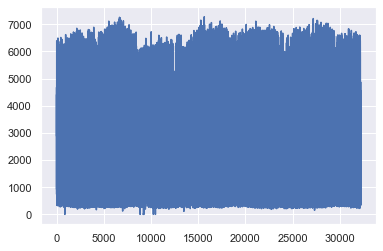

In [9]:
plt.plot(raw_df['traffic_volume'])
plt.show()

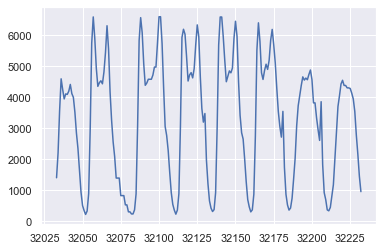

In [11]:
plt.plot(raw_df['traffic_volume'].tail(200))

## Verify data are time series
* the only column considered as a time index
* the column is sorted
* the column has stable frequency



In [12]:
df = raw_df.set_index('date_time')
df.index = pd.to_datetime(df.index)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2015-06-11 20:00:00,None,287.586,0.0,0.0,92,Rain,light rain,2886
2015-06-12 18:00:00,None,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2015-06-12 20:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3095
2015-06-12 21:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3299
2015-06-13 21:00:00,None,294.840,0.0,0.0,76,Clouds,broken clouds,3040


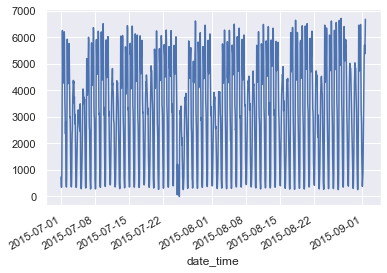

In [13]:
df.loc['2015-07-01': '2015-09-01', 'traffic_volume'].plot()

## Task 1
* implement transformer **MakeTSTransformer** which makes the dataset timeseries

In [15]:
class MakeTSTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_column):
        self.date_column = date_column
    
    #even if nothing to fit, this method must return self
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X = X.set_index(self.date_column)
        X.index = pd.to_datetime(X.index)
        return X

ts_transformer = MakeTSTransformer(date_column='date_time')
ts_transformer.fit(raw_df)
ts_transformer.transform(raw_df).head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2015-06-11 20:00:00,None,287.586,0.0,0.0,92,Rain,light rain,2886
2015-06-12 18:00:00,None,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2015-06-12 20:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3095
2015-06-12 21:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3299
2015-06-13 21:00:00,None,294.840,0.0,0.0,76,Clouds,broken clouds,3040


2. Column is **sorted**

In [16]:
# next condition is to check if the dataset timeseries is sorted
(df.index == df.index.sort_values()).all()

# if not, then we can sort it
# df = df.sort_index()

True

3. Stable **frequency**

In [17]:
# difference between all rows is 1H (1D etc.)
print(pd.infer_freq(df.index)) # suggests the frequency

None


**Conclusion: the data are not time series. Modifications are required including resampling to daily data**

# Exploratory Data Analysis

Here we need to decide which columns we can remove and what to do with other columns.

In [18]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'traffic_volume'],
      dtype='object')

In [20]:
cat_columns = df.select_dtypes(exclude=np.number).columns.tolist()
cat_columns

['holiday', 'weather_main', 'weather_description']

In [21]:
# values for category columns
for col in cat_columns:
    print(f'{col}: {df[col].nunique()}')
    print(df[col].unique())
    print()

holiday: 12
['None' 'Independence Day' 'State Fair' 'Labor Day' 'Columbus Day'
 'Veterans Day' 'Thanksgiving Day' 'Christmas Day' 'New Years Day'
 'Washingtons Birthday' 'Memorial Day' 'Martin Luther King Jr Day']

weather_main: 11
['Rain' 'Clear' 'Clouds' 'Haze' 'Thunderstorm' 'Mist' 'Fog' 'Drizzle'
 'Smoke' 'Snow' 'Squall']

weather_description: 37
['light rain' 'Sky is Clear' 'sky is clear' 'broken clouds' 'few clouds'
 'scattered clouds' 'moderate rain' 'haze' 'proximity thunderstorm' 'mist'
 'fog' 'heavy intensity rain' 'drizzle' 'thunderstorm'
 'light intensity drizzle' 'overcast clouds'
 'thunderstorm with heavy rain' 'very heavy rain' 'smoke'
 'proximity shower rain' 'thunderstorm with light rain'
 'proximity thunderstorm with drizzle' 'thunderstorm with rain'
 'thunderstorm with light drizzle' 'heavy intensity drizzle'
 'proximity thunderstorm with rain' 'light rain and snow' 'light snow'
 'snow' 'heavy snow' 'light intensity shower rain'
 'thunderstorm with drizzle' 'SQUALLS'

### Weather

In [22]:
for value in df['weather_main'].unique():
    weather_descr = df[df['weather_main']==value]['weather_description'].unique()
    print(f'{value} : {weather_descr}')
    print()

Rain : ['light rain' 'moderate rain' 'heavy intensity rain' 'very heavy rain'
 'proximity shower rain' 'light intensity shower rain' 'freezing rain']

Clear : ['Sky is Clear' 'sky is clear']

Clouds : ['broken clouds' 'few clouds' 'scattered clouds' 'overcast clouds']

Haze : ['haze']

Thunderstorm : ['proximity thunderstorm' 'thunderstorm' 'thunderstorm with heavy rain'
 'thunderstorm with light rain' 'proximity thunderstorm with drizzle'
 'thunderstorm with rain' 'thunderstorm with light drizzle'
 'proximity thunderstorm with rain' 'thunderstorm with drizzle']

Mist : ['mist']

Fog : ['fog']

Drizzle : ['drizzle' 'light intensity drizzle' 'heavy intensity drizzle'
 'shower drizzle']

Smoke : ['smoke']

Snow : ['light rain and snow' 'light snow' 'snow' 'heavy snow'
 'light shower snow' 'sleet']

Squall : ['SQUALLS']



In [24]:
df['weather_main'].value_counts()

Clear           9656
Clouds          8594
Mist            4191
Rain            3853
Snow            1926
Drizzle         1454
Haze             993
Thunderstorm     846
Fog              699
Smoke             20
Squall             1
Name: weather_main, dtype: int64

In [25]:
df['weather_main'].value_counts() / df.shape[0] * 100

Clear           29.956876
Clouds          26.662116
Mist            13.002203
Rain            11.953588
Snow             5.975243
Drizzle          4.510905
Haze             3.080694
Thunderstorm     2.624639
Fog              2.168585
Smoke            0.062048
Squall           0.003102
Name: weather_main, dtype: float64

We need to group the categories with frequency

In [26]:
# preciptiation - rain
(df['rain_1h'].value_counts()) / df.shape[0]*100

0.00     94.021655
0.25      1.405392
0.51      0.434337
0.30      0.291627
1.02      0.276115
           ...    
2.83      0.003102
10.05     0.003102
5.06      0.003102
7.70      0.003102
3.56      0.003102
Name: rain_1h, Length: 228, dtype: float64

In [27]:
(df['snow_1h'].value_counts()) / df.shape[0]*100

0.00    99.804548
0.05     0.043434
0.06     0.037229
0.10     0.018614
0.13     0.018614
0.51     0.018614
0.25     0.018614
0.32     0.015512
0.17     0.009307
0.08     0.006205
0.44     0.006205
0.21     0.003102
Name: snow_1h, dtype: float64

In [28]:
(df['clouds_all'].value_counts()) / df.shape[0]*100

90     35.119288
1      30.595973
75     11.339311
40      9.490274
5       3.242019
20      3.155152
0       2.947290
92      0.915211
8       0.412621
12      0.394006
80      0.266807
36      0.248193
32      0.241988
56      0.238886
24      0.238886
88      0.226476
68      0.226476
48      0.204759
64      0.167530
76      0.155121
44      0.108584
100     0.065151
Name: clouds_all, dtype: float64

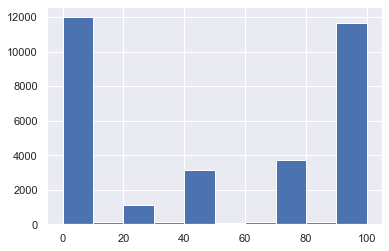

In [31]:
df['clouds_all'].hist()

In [32]:
df['holiday'].value_counts()

None                         32190
Labor Day                        6
Martin Luther King Jr Day        5
Independence Day                 4
Thanksgiving Day                 4
Christmas Day                    4
State Fair                       4
New Years Day                    4
Memorial Day                     3
Washingtons Birthday             3
Columbus Day                     3
Veterans Day                     3
Name: holiday, dtype: int64

In [33]:
holiday_dates = df.holiday[df.holiday != 'None'].index
holiday_dates

DatetimeIndex(['2015-07-03', '2015-08-27', '2015-09-07', '2015-10-12',
               '2015-11-11', '2015-11-26', '2015-11-26', '2015-12-25',
               '2016-01-01', '2016-01-01', '2016-02-15', '2016-05-30',
               '2016-07-04', '2016-08-25', '2016-09-05', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2016-12-26', '2017-01-02', '2017-01-16', '2017-01-16',
               '2017-02-20', '2017-05-29', '2017-07-04', '2017-08-24',
               '2017-09-04', '2017-10-09', '2017-11-10', '2017-11-23',
               '2017-12-25', '2018-01-01', '2018-01-15', '2018-01-15',
               '2018-01-15', '2018-02-19', '2018-05-28', '2018-07-04',
               '2018-08-23', '2018-09-03', '2018-09-03'],
              dtype='datetime64[ns]', name='date_time', freq=None)

### Conclusion:
1. Holiday => to be turned to binary value
2. 'Weather main' => categories to be reduced based on the 10% threshold to reduce dimensionality
3. **Columns to remove**:
    * 'rain_1h' - low variance, redundant
    * 'snow_1h' - very low variance, reduntant
    * 'clouds_all' - redundant, not meaningful
    * 'weather_description' - redundant

# Task 2
* implement transformer for columns dropping
* implement pipeline with MakeTSTransformer and dropping columns

### TRANSFORMER

In [34]:
class RemoveColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, columns_to_remove: list):
        self.columns_to_remove = columns_to_remove
        
    # even if nothing to fit, this method must return self
    def fit( self, X, y = None ):
        return self
    
    def transform( self, X, y = None ):
        return X.drop(self.columns_to_remove, axis=1)

In [35]:
pipeline = Pipeline(steps=[
    ('time_series', MakeTSTransformer(date_column='date_time')),
    ('drop_columns', RemoveColumnsTransformer(['rain_1h', 'snow_1h', 'clouds_all', 'weather_description']))
])

pipeline.fit(raw_df)


Pipeline(steps=[('time_series', MakeTSTransformer(date_column='date_time')),
                ('drop_columns',
                 RemoveColumnsTransformer(columns_to_remove=['rain_1h',
                                                             'snow_1h',
                                                             'clouds_all',
                                                             'weather_description']))])

In [69]:
pipeline.transform(raw_df).head(20)

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-06-11 20:00:00,0,287.586,Rain,2886
2015-06-12 18:00:00,0,297.543,Clear,4380
2015-06-12 20:00:00,0,292.061,Clear,3095
2015-06-12 21:00:00,0,292.061,Clear,3299
2015-06-13 21:00:00,0,294.840,Clouds,3040
2015-06-13 23:00:00,0,293.137,Clouds,2051
2015-06-14 20:00:00,0,296.064,Rain,2909
2015-06-19 18:00:00,0,299.007,Clear,4681
2015-06-20 18:00:00,0,295.369,Rain,4045


# Task 3
* implement transforemer which will turn holiday into binary column

In [37]:
class HolidayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, holiday_column):
        self.holiday_column = holiday_column
    
    def fit(self, X, y = None):
        pass
    
    def transform(self, X, y = None):
        if X[self.holiday_column] == 'None':
            X[self.holiday_column] = 0
        else:
            X[self.holiday_column] = 1
        return X

# X['holiday'] = X['holiday'].apply(lambda x: 0 if x=='None' else 1)

In [41]:
class HolidayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        #self.holiday_col = holiday_col
        pass
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        #X[self.holiday_col] = X[self.holiday_col].apply(lambda x: 0 if x=='None' else 1)
        X['holiday'] = X['holiday'].apply(lambda x: 0 if x=='None' else 1)
        return X

In [44]:
X_1 = raw_df.copy()
holiday_df = HolidayTransformer().fit_transform(X_1)
X_1.head()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2015-06-11 20:00:00,0,287.586,0.0,0.0,92,Rain,light rain,2886
1,2015-06-12 18:00:00,0,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2,2015-06-12 20:00:00,0,292.061,0.0,0.0,8,Clear,sky is clear,3095
3,2015-06-12 21:00:00,0,292.061,0.0,0.0,8,Clear,sky is clear,3299
4,2015-06-13 21:00:00,0,294.840,0.0,0.0,76,Clouds,broken clouds,3040


In [45]:
holiday_df['holiday'].unique()

array([0, 1])

# Task 4 
* all the categories but 'clear', clouds, mist, rain go to new category other

In [61]:
class WeatherTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass 
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        categories = ['Clouds', 'Clear', 'Mist', 'Rain']
        X['weather_main'] = X['weather_main'].apply(lambda x: 'Other' if x not in categories else x)
        return X

In [62]:
X_1 = raw_df.copy()
weather_main = WeatherTransformer().transform(X_1)

In [63]:
weather_main.head()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2015-06-11 20:00:00,None,287.586,0.0,0.0,92,Rain,light rain,2886
1,2015-06-12 18:00:00,None,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2,2015-06-12 20:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3095
3,2015-06-12 21:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3299
4,2015-06-13 21:00:00,None,294.840,0.0,0.0,76,Clouds,broken clouds,3040


In [64]:
weather_main['weather_main'].unique()

array(['Rain', 'Clear', 'Clouds', 'Other', 'Mist'], dtype=object)

In [65]:
weather_main['weather_main'].value_counts()

Clear     9656
Clouds    8594
Other     5939
Mist      4191
Rain      3853
Name: weather_main, dtype: int64

In [66]:
weather_main['weather_main'].value_counts() / df.shape[0] * 100

Clear     29.956876
Clouds    26.662116
Other     18.425216
Mist      13.002203
Rain      11.953588
Name: weather_main, dtype: float64

# Task 5
* create pipeline extending pipeline from task 2 by handling holiday and main_weather columns
* transformed dataset write to the variable df_reduced

In [68]:
pipeline = Pipeline(steps=[
    ('time_series', MakeTSTransformer(date_column='date_time')),
    ('drop_columns', RemoveColumnsTransformer(['rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('holiday_encoder', HolidayTransformer()),
    ('main_weather', WeatherTransformer())
])

pipeline.fit(raw_df)
pipeline.transform(raw_df).head(20)

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-06-11 20:00:00,0,287.586,Rain,2886
2015-06-12 18:00:00,0,297.543,Clear,4380
2015-06-12 20:00:00,0,292.061,Clear,3095
2015-06-12 21:00:00,0,292.061,Clear,3299
2015-06-13 21:00:00,0,294.840,Clouds,3040
2015-06-13 23:00:00,0,293.137,Clouds,2051
2015-06-14 20:00:00,0,296.064,Rain,2909
2015-06-19 18:00:00,0,299.007,Clear,4681
2015-06-20 18:00:00,0,295.369,Rain,4045


In [70]:
df_reduced = pipeline.transform(raw_df)

In [71]:
df_reduced

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-06-11 20:00:00,0,287.586,Rain,2886
2015-06-12 18:00:00,0,297.543,Clear,4380
2015-06-12 20:00:00,0,292.061,Clear,3095
2015-06-12 21:00:00,0,292.061,Clear,3299
2015-06-13 21:00:00,0,294.840,Clouds,3040
...,...,...,...,...
2018-09-30 19:00:00,0,283.450,Clouds,3543
2018-09-30 20:00:00,0,282.760,Clouds,2781
2018-09-30 21:00:00,0,282.730,Other,2159


we have less columns now. Thus, resampling will cause less challenges.

# Why the frequency is not stable?
* missing indexes
* duplicates

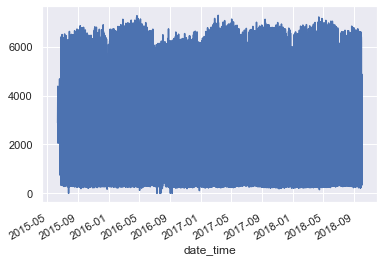

In [72]:
df_reduced['traffic_volume'].plot()

In [74]:
df_reduced.loc['2015-01':].head(10)

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-06-11 20:00:00,0,287.586,Rain,2886
2015-06-12 18:00:00,0,297.543,Clear,4380
2015-06-12 20:00:00,0,292.061,Clear,3095
2015-06-12 21:00:00,0,292.061,Clear,3299
2015-06-13 21:00:00,0,294.840,Clouds,3040
2015-06-13 23:00:00,0,293.137,Clouds,2051
2015-06-14 20:00:00,0,296.064,Rain,2909
2015-06-19 18:00:00,0,299.007,Clear,4681
2015-06-20 18:00:00,0,295.369,Rain,4045


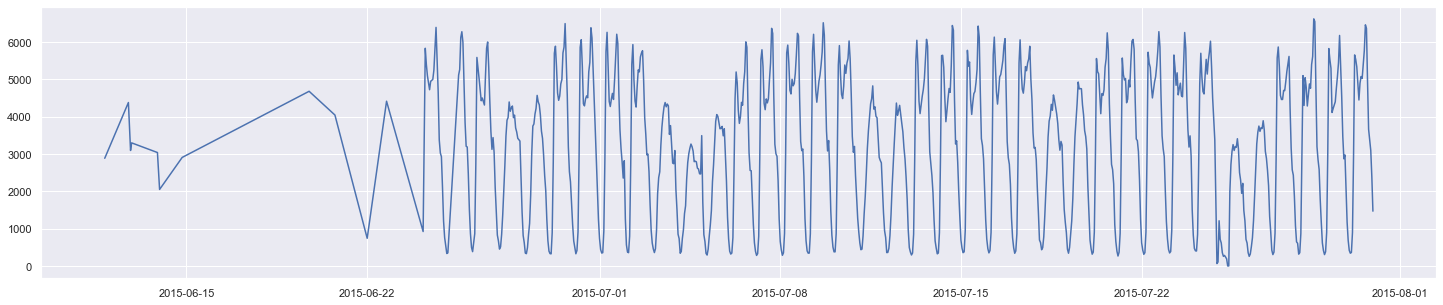

In [75]:
plt.figure(figsize=(25,5))
plt.plot(df_reduced.loc['2015-6-11':'2015-07-30', 'traffic_volume'])

In [77]:
df_reduced = df_reduced['2015-07':]
df_reduced.head()

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-01 00:00:00,0,289.20,Clear,737
2015-07-01 01:00:00,0,289.40,Clear,444
2015-07-01 02:00:00,0,289.19,Clear,347
2015-07-01 03:00:00,0,288.74,Rain,356
2015-07-01 04:00:00,0,288.07,Clear,936


We can consider data starting **from July 2015** because of big gap in data. Still we have queite long history - over 3 years
* check if there are missing indexes
* check if thre are duplicates indexes

In [78]:
# if there are missing indexes
df_reduced.index.isnull().sum()

0

# Task 5.1
* create transformer CutDateTransformer which takes dataset from speified date, e.g. 2015-07-01
* extend the pipeline form task 5

In [83]:
class CutDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_to_cut:str):
        self.date_to_cut = date_to_cut
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return X.loc[self.date_to_cut:]
    


In [84]:
pipeline = Pipeline(steps=[
    ('time_series', MakeTSTransformer(date_column='date_time')),
    ('drop_columns', RemoveColumnsTransformer(['rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('holiday_encoder', HolidayTransformer()),
    ('main_weather', WeatherTransformer()),
    ('cut_date', CutDateTransformer('2015-07-01'))
])

pipeline.fit(raw_df)
pipeline.transform(raw_df).head(20)

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-01 00:00:00,0,289.20,Clear,737
2015-07-01 01:00:00,0,289.40,Clear,444
2015-07-01 02:00:00,0,289.19,Clear,347
2015-07-01 03:00:00,0,288.74,Rain,356
2015-07-01 04:00:00,0,288.07,Clear,936
2015-07-01 05:00:00,0,287.87,Clear,2886
2015-07-01 06:00:00,0,287.38,Clear,5741
2015-07-01 07:00:00,0,287.58,Clouds,6261
2015-07-01 09:00:00,0,288.58,Clouds,4409


# Duplicates

In [85]:
df_reduced.index.duplicated().sum()

5519

In [86]:
df_reduced[df_reduced.index.duplicated()].head()

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-04 01:00:00,0,290.88,Mist,851
2015-07-04 02:00:00,0,290.70,Mist,735
2015-07-04 02:00:00,0,290.70,Other,735
2015-07-04 03:00:00,0,290.49,Mist,341
2015-07-04 03:00:00,0,290.49,Other,341


In [87]:
df_reduced.loc['2015-07-04': '2015-07-05'].head(8)

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-04 00:00:00,0,291.76,Other,1512
2015-07-04 01:00:00,0,290.88,Other,851
2015-07-04 01:00:00,0,290.88,Mist,851
2015-07-04 02:00:00,0,290.70,Other,735
2015-07-04 02:00:00,0,290.70,Mist,735
2015-07-04 02:00:00,0,290.70,Other,735
2015-07-04 03:00:00,0,290.49,Other,341
2015-07-04 03:00:00,0,290.49,Mist,341


### Duplicates: volume traffic is the same but the weather changed. Duplicates can be removed

In [88]:
# condition to filter out duplicated values
not_duplicated = ~df_reduced.index.duplicated() #tylda oznacza not
df_no_duplicates = df_reduced.loc[not_duplicated]
df_no_duplicates.head()

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-01 00:00:00,0,289.20,Clear,737
2015-07-01 01:00:00,0,289.40,Clear,444
2015-07-01 02:00:00,0,289.19,Clear,347
2015-07-01 03:00:00,0,288.74,Rain,356
2015-07-01 04:00:00,0,288.07,Clear,936


In [89]:
df_no_duplicates.index.duplicated().sum()

0

In [90]:
df_no_duplicates.shape

(26528, 4)

# Task 6
* create transformer to remove duplicated indexes

In [91]:
class RemoveDuplicatesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        not_duplicated = ~X.index.duplicated()
        X = X.loc[not_duplicated]
        return X

In [92]:
rdt = RemoveDuplicatesTransformer()
no_dupl_X = rdt.fit_transform(raw_df)
no_dupl_X.index.duplicated().sum()

0

# Missing Values
missing values for existing indexes

In [93]:
df_no_duplicates.isna().sum()

holiday           0
temp              0
weather_main      0
traffic_volume    0
dtype: int64

In [95]:
df_no_duplicates.shape

(26528, 4)

In [96]:
# all the time steps from min to max date within our dateset with specified frequency
full_idx = pd.date_range(start=df_no_duplicates.index.min(), end=df_no_duplicates.index.max(), freq='1H')
print(full_idx[:5])

DatetimeIndex(['2015-07-01 00:00:00', '2015-07-01 01:00:00',
               '2015-07-01 02:00:00', '2015-07-01 03:00:00',
               '2015-07-01 04:00:00'],
              dtype='datetime64[ns]', freq='H')


In [97]:
len(full_idx)

28512

In [98]:
# missing indexes - those which present in full_idx but absent in the dataset
missing_indexes = ~full_idx.isin(df_no_duplicates.index) # True if missing otherwise False
print(f'Number of missing values/indexes: {np.sum(missing_indexes)}')
print(f'Pecentage form entire dataset: {np.mean(missing_indexes)}')

Number of missing values/indexes: 1984
Pecentage form entire dataset: 0.06958473625140292


In [99]:
missing_indexes

array([False, False, False, ..., False, False, False])

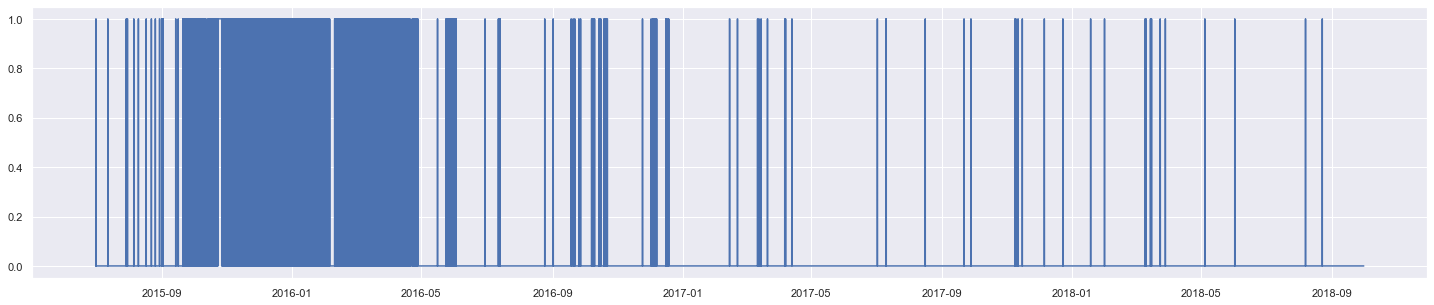

In [100]:
missing_indexes_df = pd.Series(missing_indexes, index=full_idx)
plt.figure(figsize=(25,5))
plt.plot(missing_indexes_df)

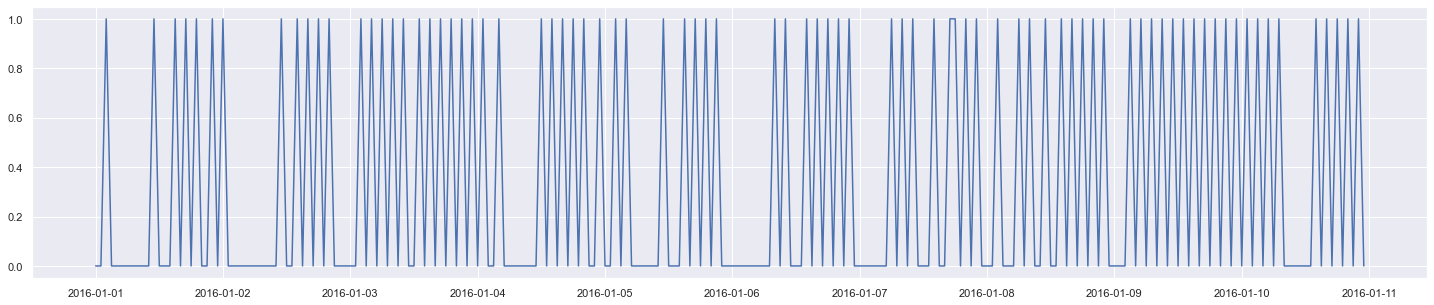

In [102]:
plt.figure(figsize=(25,5))
plt.plot(missing_indexes_df.loc['2016-01-01': '2016-01-10'])

# Resample Data
## Hourly
We are interesed in daily values. But before this, we need to fill missing hourly values otherwise during the aggregation (especially sum) the daily value will be significantly underestimated..


In [103]:
df_no_duplicates.head()

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-01 00:00:00,0,289.20,Clear,737
2015-07-01 01:00:00,0,289.40,Clear,444
2015-07-01 02:00:00,0,289.19,Clear,347
2015-07-01 03:00:00,0,288.74,Rain,356
2015-07-01 04:00:00,0,288.07,Clear,936


In [104]:
df_no_duplicates.index = pd.to_datetime(df_no_duplicates.index)

In [107]:
df_res_H = pd.DataFrame()
# interpolate missing values
df_res_H['traffic_volume'] = df_no_duplicates['traffic_volume'].resample('1H').mean().interpolate()
df_res_H['temp'] = df_no_duplicates['temp'].resample('1H').mean().interpolate()
# impute by fill forward
df_res_H['weather_main'] = df_no_duplicates['weather_main'].resample('1H').ffill()
df_res_H['holiday'] = df_no_duplicates['holiday'].resample('1H').ffill()

In [108]:
df_res_H.head()

,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01 00:00:00,737.0,289.20,Clear,0
2015-07-01 01:00:00,444.0,289.40,Clear,0
2015-07-01 02:00:00,347.0,289.19,Clear,0
2015-07-01 03:00:00,356.0,288.74,Rain,0
2015-07-01 04:00:00,936.0,288.07,Clear,0


In [109]:
print(pd.infer_freq(df_res_H.index))

H


# Task 7
* create transformer for hourly rresampling the dataset
* extend the pipeline from task 5 by duplicates transformer and hourly resampling
* check if the transformed dataset has H frequency

In [119]:
class HourlyResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df_res_H = pd.DataFrame()
        
        # interpolate missing values
        df_res_H['traffic_volume'] = X['traffic_volume'].resample('1H').mean().interpolate()
        df_res_H['temp'] = X['temp'].resample('1H').mean().interpolate()
        
        # impute by fill forward
        df_res_H['weather_main'] = X['weather_main'].resample('1H').ffill()
        df_res_H['holiday'] = X['holiday'].resample('1H').ffill()
        
        return df_res_H

In [141]:
pipeline = Pipeline(steps=[
    ('time_series', MakeTSTransformer(date_column='date_time')),
    ('drop_columns', RemoveColumnsTransformer(['rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('holiday_encoder', HolidayTransformer()),
    ('main_weather', WeatherTransformer()),
    ('cut_date', CutDateTransformer('2015-07-01')),
    ('remove_duplicates', RemoveDuplicatesTransformer()),
    ('resample', HourlyResampleTransformer())
])

pipeline.fit(raw_df)
pipeline.transform(raw_df).head()



,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01 00:00:00,737.0,289.20,Clear,0
2015-07-01 01:00:00,444.0,289.40,Clear,0
2015-07-01 02:00:00,347.0,289.19,Clear,0
2015-07-01 03:00:00,356.0,288.74,Rain,0
2015-07-01 04:00:00,936.0,288.07,Clear,0


In [124]:
print(pd.infer_freq(pipeline.transform(raw_df).index))


H


# Daily
During the downsampling process (from Hourly to Daily) the aggrogation method should be selected for each column:
* traffic volume - sum during the day
* temperature - average during the day
* weather - the most often during the day
* holiday = max of the day (if there is 1 during the day than 1 otherwise 0)

In [126]:
df_res_H.loc['2015-09-01']['weather_main'].value_counts()

Other    12
Rain      6
Clear     5
Mist      1
Name: weather_main, dtype: int64

In [129]:
df_res_D = pd.DataFrame()
df_res_D['traffic_volume'] = df_res_H['traffic_volume'].resample('1D').sum()
df_res_D['temp'] = df_res_H['temp'].resample('1D').mean()
df_res_D['weather_main'] = df_res_H['weather_main'].resample('1D').apply(lambda x: stats.mode(x)[0][0])
df_res_D['holiday'] = df_res_H['holiday'].resample('1D').max()

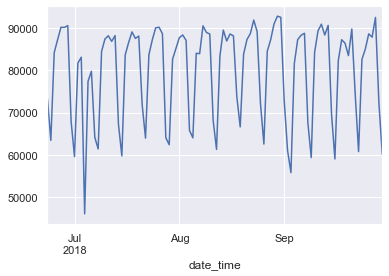

In [132]:
df_res_D['traffic_volume'][-100:].plot()

In [133]:
print(pd.infer_freq(df_res_D.index))

D


# Task 8
* create transform for daily resampling the dataset
* extend the pipeline from task 7 
* check if the transformed dataset has D frequency

In [134]:
class DailyResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        pass
    
    def transform(self, X, y=None):
        df_res_D = pd.DataFrame()
        df_res_D['traffic_volume'] = X['traffic_volume'].resample('1D').sum()
        df_res_D['temp'] = X['temp'].resample('1D').mean()
        df_res_D['weather_main'] = X['weather_main'].resample('1D').apply(lambda x: stats.mode(x)[0][0])
        df_res_D['holiday'] = X['holiday'].resample('1D').max()
        return df_res_D

In [161]:
pipeline = Pipeline(steps=[
    ('time_series', MakeTSTransformer(date_column='date_time')),
    ('drop_columns', RemoveColumnsTransformer(['rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('holiday_encoder', HolidayTransformer()),
    ('main_weather', WeatherTransformer()),
    ('cut_date', CutDateTransformer('2015-07-01')),
    ('remove_duplicates', RemoveDuplicatesTransformer()),
    ('resample', HourlyResampleTransformer()),
    ('resample_D', DailyResampleTransformer())
])

pipeline.fit(raw_df)
pipeline.transform(raw_df).head(20)


,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01,87440.0,290.721250,Clear,0
2015-07-02,86035.0,291.581667,Clear,0
2015-07-03,64366.0,293.042500,Clear,1
2015-07-04,51400.0,295.751667,Other,0
2015-07-05,56563.0,297.172083,Clear,0
2015-07-06,77663.0,293.514167,Rain,0
2015-07-07,84266.0,289.291250,Clear,0
2015-07-08,87620.0,290.508333,Clear,0
2015-07-09,89488.0,293.528333,Clear,0


In [138]:
print(pd.infer_freq(pipeline.transform(raw_df).index))


D


# Outliers
we want to cut upper 0.5% of values as well as lower 0.5% of values to get rid of suspicious values

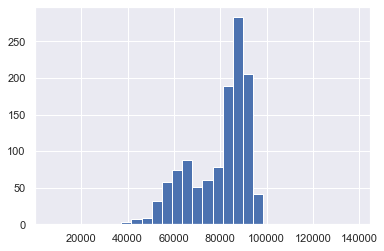

41187 97374


In [142]:
y = df_res_D['traffic_volume']
y.hist(bins=30)
plt.show()
low, high = round(np.percentile(y, 0.5)), round(np.percentile(y, 99.5))
print(low, high)

In [143]:
low_99, high_99 = round(np.percentile(y, 1)), round(np.percentile(y, 99))
print(low_99, high_99)

45279 96861


In [145]:
def f(low, high, x):
    if x < low:
        x = low
    elif x > high:
        x = high
    return x

y_no_outliers = y.copy()
y_no_outliers = y_no_outliers.apply(lambda x: f(low, high, x))
print((y != y_no_outliers).sum())

12


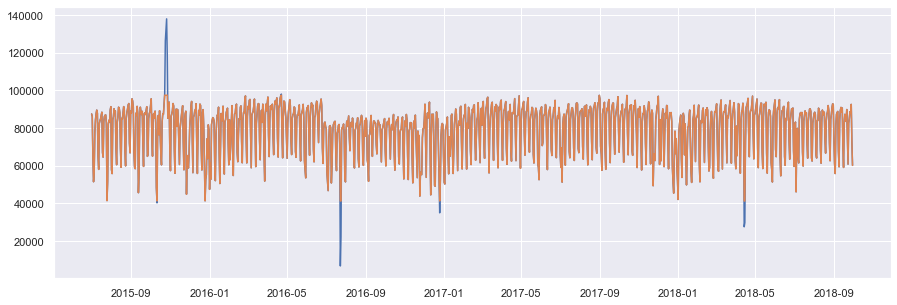

In [147]:
plt.figure(figsize=(15,5))
plt.plot(y)
plt.plot(y_no_outliers)
plt.show()

In [148]:
df_res_D['traffic_volume'] = y_no_outliers

# Task 9
* implement transformer **VolumeRemoveOutliersTransformer** with passing percentiles like [1,99]
* extend the previous pipeline

In [240]:
class VolumeRemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, percentiles=[1,99]):
        self.percentiles = percentiles
        self.boundaries = None
        self.col = 'traffic_volume'
    def fit( self, X, y = None ):
        lower = round(np.percentile(X[self.col], self.percentiles[0]))
        upper = round(np.percentile(X[self.col], self.percentiles[1]))
        self.boundaries = [lower, upper]
        return self
    def transform( self, X, y = None ):
        # low, high = self.percentile
        # X['traffic_volume'] = [np.clip(x, low, high) for x in X['traffic_volume']]
        def f(low, high, x):
            if x < low:
                x = low
            elif x > high:
                x = high
            return x
        low = self.boundaries[0]
        high = self.boundaries[1]
        X[self.col] = X[self.col].apply(lambda x: f(low, high, x))
        return X

In [241]:
pipeline = Pipeline(steps=[
    ('time_series', MakeTSTransformer(date_column='date_time')),
    ('drop_columns', RemoveColumnsTransformer(['rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('holiday_encoder', HolidayTransformer()),
    ('main_weather', WeatherTransformer()),
    ('cut_date', CutDateTransformer('2015-07-01')),
    ('remove_duplicates', RemoveDuplicatesTransformer()),
    ('resample', HourlyResampleTransformer()),
    ('resample_D', DailyResampleTransformer()),
#     ('remove_outliers', VolumeRemoveOutliersTransformer())
])

pipeline.fit(raw_df)
pipeline.transform(raw_df).head(20)
# type(pipeline)

,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01,87440.0,290.721250,Clear,0
2015-07-02,86035.0,291.581667,Clear,0
2015-07-03,64366.0,293.042500,Clear,1
2015-07-04,51400.0,295.751667,Other,0
2015-07-05,56563.0,297.172083,Clear,0
2015-07-06,77663.0,293.514167,Rain,0
2015-07-07,84266.0,289.291250,Clear,0
2015-07-08,87620.0,290.508333,Clear,0
2015-07-09,89488.0,293.528333,Clear,0


# Date-related features

In [177]:
df_features = df_res_D.copy()
df_features.head()

,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01,87440.0,290.721250,Clear,0
2015-07-02,86035.0,291.581667,Clear,0
2015-07-03,64366.0,293.042500,Clear,1
2015-07-04,51400.0,295.751667,Other,0
2015-07-05,56563.0,297.172083,Clear,0


In [178]:
def generate_date_features(df_features):
    df_features['date'] = pd.to_datetime(df_features.index)
    df_features['month'] = df_features['date'].dt.month
    df_features['month_day'] = df_features['date'].dt.day
    df_features['day_of_week'] = df_features['date'].dt.dayofweek # 0 - Monday; 6 - Sunday
    df_features['is_weekend'] = np.where(df_features['day_of_week'].isin([5, 6]), 1, 0)
    return df_features

In [180]:
df_features = generate_date_features(df_features)
df_features.head()

,traffic_volume,temp,weather_main,holiday,date,month,month_day,day_of_week,is_weekend
date_time,,,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,2015-07-01,7,1,2,0
2015-07-02,86035.0,291.581667,Clear,0,2015-07-02,7,2,3,0
2015-07-03,64366.0,293.042500,Clear,1,2015-07-03,7,3,4,0
2015-07-04,51400.0,295.751667,Other,0,2015-07-04,7,4,5,1
2015-07-05,56563.0,297.172083,Clear,0,2015-07-05,7,5,6,1


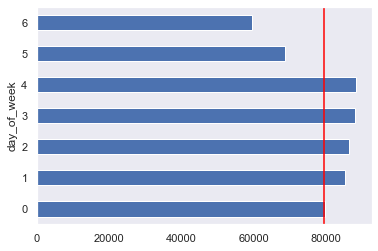

In [181]:
# depending on the day of week
df_features.groupby('day_of_week').mean()['traffic_volume'].plot.barh()
plt.vlines(df_features['traffic_volume'].mean(), ymin=-1, ymax=7, color='red')
plt.grid()

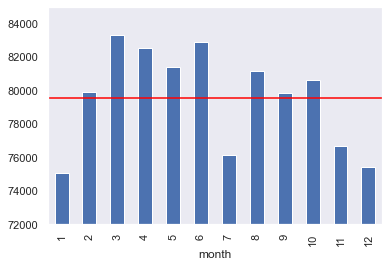

In [182]:
# depending on the month
df_features.groupby('month').mean()['traffic_volume'].plot.bar()
plt.hlines(df_features['traffic_volume'].mean(), xmin=-1, xmax=12, color='red')
plt.ylim(72000, 85000)
plt.grid()

(72000.0, 85000.0)

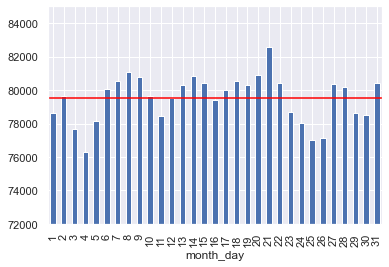

In [183]:
# depending on the day of month
df_features.groupby('month_day').mean()['traffic_volume'].plot.bar()
plt.hlines(df_features['traffic_volume'].mean(), xmin=-1, xmax=32, color='red')
plt.ylim(72000, 85000)

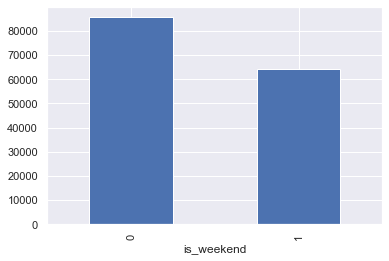

In [184]:
df_features.groupby('is_weekend').mean()['traffic_volume'].plot.bar()

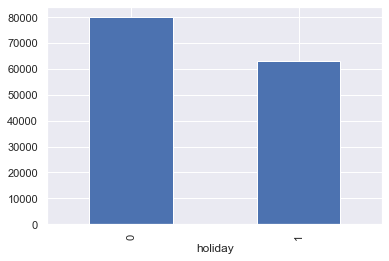

In [185]:
df_features.groupby('holiday').mean()['traffic_volume'].plot.bar()

# Conclusion for date related feautres:
* feature 'month_day' doesn't show any impact on the traffic volume so we may remove them
* other features should be kept

In [187]:
df_features = df_features.drop(['month_day', 'date'], axis=1)
df_features.head()

,traffic_volume,temp,weather_main,holiday,month,day_of_week,is_weekend
date_time,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,7,2,0
2015-07-02,86035.0,291.581667,Clear,0,7,3,0
2015-07-03,64366.0,293.042500,Clear,1,7,4,0
2015-07-04,51400.0,295.751667,Other,0,7,5,1
2015-07-05,56563.0,297.172083,Clear,0,7,6,1


# Trend and Seasonality

In [188]:
series = df_features['traffic_volume']

In [189]:
result = seasonal_decompose(series)

In [190]:
df_features['seasonality'] = result.seasonal
df_features['trend'] = result.trend

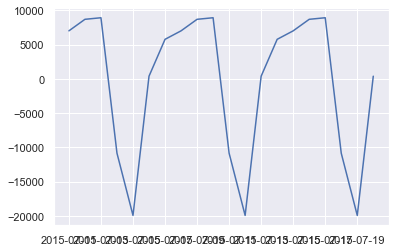

In [192]:
plt.plot(df_features['seasonality'].head(20))

In [191]:
result.seasonal.head()

date_time
2015-07-01     7009.368540
2015-07-02     8691.407213
2015-07-03     8920.239941
2015-07-04   -10848.711567
2015-07-05   -19931.251691
Freq: D, Name: seasonal, dtype: float64

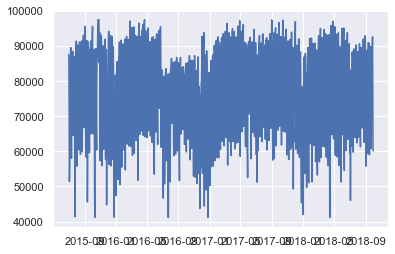

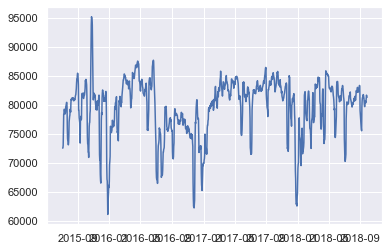

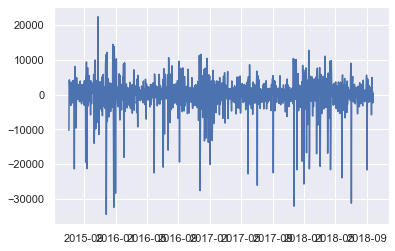

In [194]:
plt.plot(series)
plt.show()

plt.plot(df_features['trend'])
plt.show()

plt.plot(result.resid)
plt.show()

In [195]:
df_features.head()

,traffic_volume,temp,weather_main,holiday,month,day_of_week,is_weekend,seasonality,trend
date_time,,,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,7,2,0,7009.368540,NaN
2015-07-02,86035.0,291.581667,Clear,0,7,3,0,8691.407213,NaN
2015-07-03,64366.0,293.042500,Clear,1,7,4,0,8920.239941,NaN
2015-07-04,51400.0,295.751667,Other,0,7,5,1,-10848.711567,72533.285714
2015-07-05,56563.0,297.172083,Clear,0,7,6,1,-19931.251691,72559.000000


# Rolling statistics

In [196]:
for i in range(2, 8):
    df_features[f'mov_avg_{i}'] = df_features['traffic_volume'].rolling(window=i).mean()
    df_features[f'mov_std_{i}'] = df_features['traffic_volume'].rolling(window=i).std()


In [197]:
df_features.head()

,traffic_volume,temp,weather_main,holiday,month,day_of_week,is_weekend,seasonality,trend,mov_avg_2,...,mov_avg_3,mov_std_3,mov_avg_4,mov_std_4,mov_avg_5,mov_std_5,mov_avg_6,mov_std_6,mov_avg_7,mov_std_7
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,7,2,0,7009.368540,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,86035.0,291.581667,Clear,0,7,3,0,8691.407213,NaN,86737.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,64366.0,293.042500,Clear,1,7,4,0,8920.239941,NaN,75200.5,...,79280.333333,12935.281610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-04,51400.0,295.751667,Other,0,7,5,1,-10848.711567,72533.285714,57883.0,...,67267.000000,17498.790158,72310.25,17489.308741,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-05,56563.0,297.172083,Clear,0,7,6,1,-19931.251691,72559.000000,53981.5,...,57443.000000,6527.640385,64591.00,15257.206232,69160.8,16703.35645,NaN,NaN,NaN,NaN


# Lagged Values


In [198]:
for i in range(1, 8):
    df_features[f'traffic_lag_{i}'] = df_features['traffic_volume'].shift(i)

In [199]:
df_features.head()

,traffic_volume,temp,weather_main,holiday,month,day_of_week,is_weekend,seasonality,trend,mov_avg_2,...,mov_std_6,mov_avg_7,mov_std_7,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_4,traffic_lag_5,traffic_lag_6,traffic_lag_7
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,7,2,0,7009.368540,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,86035.0,291.581667,Clear,0,7,3,0,8691.407213,NaN,86737.5,...,NaN,NaN,NaN,87440.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,64366.0,293.042500,Clear,1,7,4,0,8920.239941,NaN,75200.5,...,NaN,NaN,NaN,86035.0,87440.0,NaN,NaN,NaN,NaN,NaN
2015-07-04,51400.0,295.751667,Other,0,7,5,1,-10848.711567,72533.285714,57883.0,...,NaN,NaN,NaN,64366.0,86035.0,87440.0,NaN,NaN,NaN,NaN
2015-07-05,56563.0,297.172083,Clear,0,7,6,1,-19931.251691,72559.000000,53981.5,...,NaN,NaN,NaN,51400.0,64366.0,86035.0,87440.0,NaN,NaN,NaN


In [200]:
df_features.shape

(1188, 28)

# Categorical Column - wather_main

(70000.0, 85000.0)

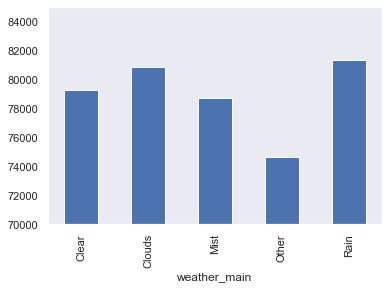

In [206]:
df_features.groupby('weather_main').mean()['traffic_volume'].plot.bar()
plt.grid()
plt.ylim(70000, 85000)

(65000.0, 85000.0)

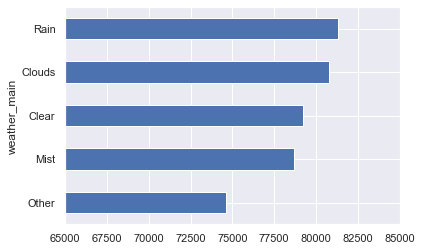

In [208]:
df_features.groupby('weather_main').mean()['traffic_volume'].sort_values().plot.barh()
plt.xlim(65000, 85000)

## Two ways of encoding
* one hot encoding
* ordinal encoding with taking inot consideration the correlation with the target

the second option gives the only dimension instead of 5 for OHE. Mapping will be like this:
* Rain - 1
* Clouds - 2
* Clear - 3
* Mist - 4
* other - 5

In [209]:
def map_weather(weather):
    d = {
        'Rain': 1,
        'Clouds': 2,
        'Clear': 3,
        'Mist': 4,
        'Other': 5,
    }
    return d[weather]

df_features['weather'] = df_features['weather_main'].apply(lambda x: map_weather(x))

In [210]:
df_features.head()

,traffic_volume,temp,weather_main,holiday,month,day_of_week,is_weekend,seasonality,trend,mov_avg_2,...,mov_avg_7,mov_std_7,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_4,traffic_lag_5,traffic_lag_6,traffic_lag_7,weather
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,7,2,0,7009.368540,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2015-07-02,86035.0,291.581667,Clear,0,7,3,0,8691.407213,NaN,86737.5,...,NaN,NaN,87440.0,NaN,NaN,NaN,NaN,NaN,NaN,3
2015-07-03,64366.0,293.042500,Clear,1,7,4,0,8920.239941,NaN,75200.5,...,NaN,NaN,86035.0,87440.0,NaN,NaN,NaN,NaN,NaN,3
2015-07-04,51400.0,295.751667,Other,0,7,5,1,-10848.711567,72533.285714,57883.0,...,NaN,NaN,64366.0,86035.0,87440.0,NaN,NaN,NaN,NaN,5
2015-07-05,56563.0,297.172083,Clear,0,7,6,1,-19931.251691,72559.000000,53981.5,...,NaN,NaN,51400.0,64366.0,86035.0,87440.0,NaN,NaN,NaN,3


In [211]:
df_features_na = df_features.dropna()
df_features_na.head()

,traffic_volume,temp,weather_main,holiday,month,day_of_week,is_weekend,seasonality,trend,mov_avg_2,...,mov_avg_7,mov_std_7,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_4,traffic_lag_5,traffic_lag_6,traffic_lag_7,weather
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-08,87620.0,290.508333,Clear,0,7,2,0,7009.368540,78370.142857,85943.0,...,72559.000000,14956.835160,84266.0,77663.0,56563.0,51400.0,64366.0,86035.0,87440.0,3
2015-07-09,89488.0,293.528333,Clear,0,7,3,0,8691.407213,78571.000000,88554.0,...,73052.285714,15521.633599,87620.0,84266.0,77663.0,56563.0,51400.0,64366.0,86035.0,3
2015-07-10,87818.0,296.469167,Clear,0,7,4,0,8920.239941,79247.285714,88653.0,...,76402.571429,15861.538995,89488.0,87620.0,84266.0,77663.0,56563.0,51400.0,64366.0,3
2015-07-11,65173.0,296.281250,Clouds,0,7,5,1,-10848.711567,79197.857143,76495.5,...,78370.142857,12802.381620,87818.0,89488.0,87620.0,84266.0,77663.0,56563.0,51400.0,2
2015-07-12,57969.0,298.381875,Clouds,0,7,6,1,-19931.251691,78801.000000,61571.0,...,78571.000000,12408.186787,65173.0,87818.0,89488.0,87620.0,84266.0,77663.0,56563.0,2


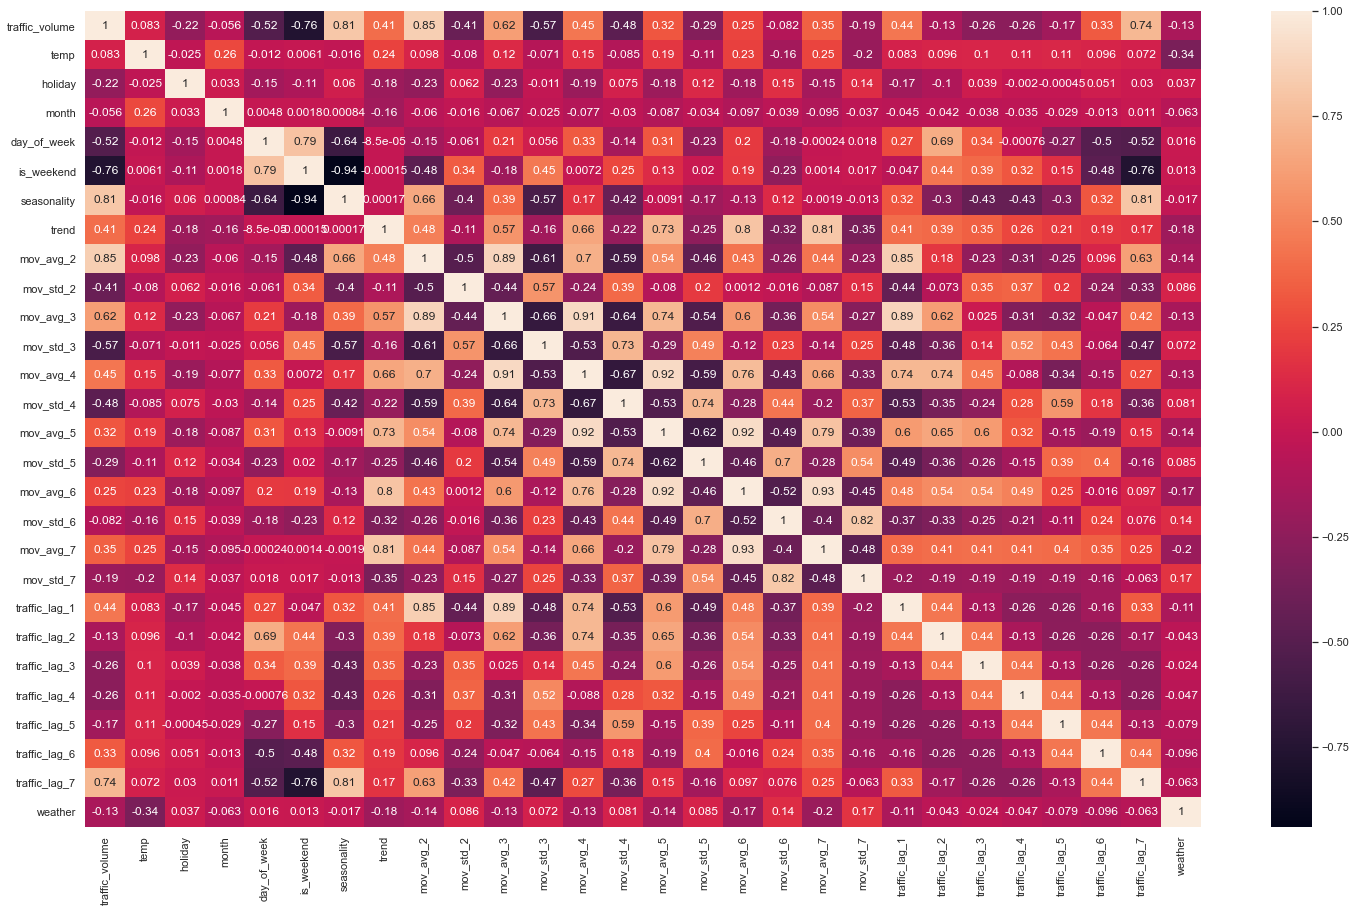

In [213]:
plt.figure(figsize=(25, 15))
sns.heatmap(df_features_na.corr(), annot=True)

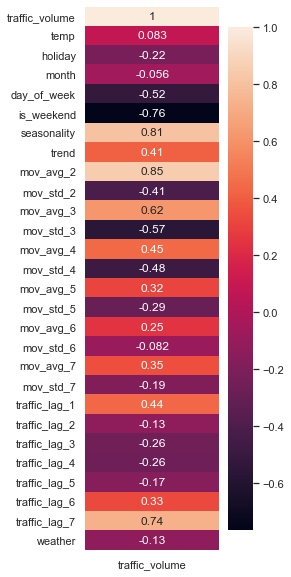

In [219]:
plt.figure(figsize=(3,10))
sns.heatmap(pd.DataFrame(df_features_na.corr()['traffic_volume']), annot=True)

In [221]:
a = df_features_na.corr()['traffic_volume']
print(a[a>0.6].index.tolist())
print(a[a<-0.6].index.tolist())

['traffic_volume', 'seasonality', 'mov_avg_2', 'mov_avg_3', 'traffic_lag_7']
['is_weekend']


# Task 10
* implement FeatureEngineering transformer whicch computes following features with correlation absolute value higher than 0.5
* extend the pipeline
* remove existing columns which are not correlated: holiday, weather

In [235]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit( self, X, y = None ):
        return self
    
    def transform( self, X, y = None ):
        df_features = X.copy()
        
        # seasonality
        df_features['seasonality'] = seasonal_decompose(df_features['traffic_volume']).seasonal
        
        # 'mov_avg_2', 'mov_avg_3', 'mov_std_3'
        df_features[f'mov_avg_2'] = df_features['traffic_volume'].rolling(window=2).mean()
        df_features[f'mov_avg_3'] = df_features['traffic_volume'].rolling(window=3).mean()
        df_features[f'mov_std_3'] = df_features['traffic_volume'].rolling(window=3).std()
        
        # 'traffic_lag_7'
        df_features['traffic_lag_7'] = df_features['traffic_volume'].shift(7)
        
        # 'day_of_week', 'is_weekend'
        df_features['date'] = df_features.index
        df_features['day_of_week'] = df_features['date'].dt.dayofweek # 0 - Monday; 6 - Sunday
        df_features['is_weekend'] = np.where(df_features['day_of_week'].isin([5, 6]),1,0)
        
        # drop missing values and unnecessary columns
        df_features = df_features.dropna()
        df_features = df_features.drop('date', axis=1)
        
        return df_features

In [247]:
columns_to_remove = ['rain_1h', 'snow_1h', 'clouds_all', 'weather_description']
columns_to_remove_2 = ['weather_main', 'holiday', 'temp']
steps = [
    ('make_ts', MakeTSTransformer(date_column='date_time')),
    ('cut_date', CutDateTransformer('2015-07-01')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('holiday', HolidayTransformer()),
    ('main_weather', WeatherTransformer()),
    ('duplicates', RemoveDuplicatesTransformer()),
    ('hourly_resample', HourlyResampleTransformer()),
    ('daily_resample', DailyResampleTransformer()),
#     ('remove_outliers', VolumeRemoveOutliersTransformer()),
#     ('features', FeatureEngineeringTransformer()),
#     ('drop_columns_again', RemoveColumnsTransformer(columns_to_remove=columns_to_remove_2))
        ]
pipeline = Pipeline(steps=steps)
pipeline.fit(raw_df)
pipeline.transform(raw_df).head(20)


,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01,87440.0,290.721250,Clear,0
2015-07-02,86035.0,291.581667,Clear,0
2015-07-03,64366.0,293.042500,Clear,1
2015-07-04,51400.0,295.751667,Other,0
2015-07-05,56563.0,297.172083,Clear,0
2015-07-06,77663.0,293.514167,Rain,0
2015-07-07,84266.0,289.291250,Clear,0
2015-07-08,87620.0,290.508333,Clear,0
2015-07-09,89488.0,293.528333,Clear,0
